# Python Citrination Client (PyCC) Batch Predictions Example

*Authors: Chris Borg*

In this notebook, we will cover how to use the PyCC to make predictions of the band gap on a collection of data. We will then use some simple statistics to quantify the accuracy of our predictions compared to the values computed in the [Materials Project database](https://materialsproject.org/). 

## Learning outcomes
By the end of this tutorial, you will learn:
* How to make predictions using PyCC and assess accuracy
* How to construct queries to search through Citrination

## Background knowledge
To get the most out of this notebook, it would be helpful to be familiar with:
* The [Materials Project API](https://materialsproject.org/docs/api) and `MPRester`
* The [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient), also referred to as Pearson's *r*


## Imports

In [1]:
# Standard Packages
from os import environ

# Third-party packages
from citrination_client import *
from pymatgen.ext.matproj import MPRester
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

## Initialize the PyCC and make a prediction

In [2]:
# Establish client (API key stored as environment variable)
client = CitrinationClient(environ['CITRINATION_API_KEY'], 'https://citrination.com')

# Example prediction
resp = client.models.predict('524', [{'Chemical formula':'GaN'},])
prediction = resp[0].get_value('Band gap')
print(prediction.value, prediction.loss)

3.4099473555967843 0.8158739805633448


## Get data from the Materials Project

In [3]:
# Generate some sample data
results = MPRester(environ['MP_API_KEY']).query("**O3", ['pretty_formula', 'band_gap'])

/usr/local/lib/python3.7/site-packages/pymatgen/core/periodic_table.py:429: UserWarning: No electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
/usr/local/lib/python3.7/site-packages/pymatgen/core/periodic_table.py:429: UserWarning: No electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
/usr/local/lib/python3.7/site-packages/pymatgen/core/periodic_table.py:429: UserWarning: No electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)


In [4]:
# Format sample data and run batch prediction on MP data
inputs = [{'Chemical formula':r['pretty_formula']} for r in results]
resp = client.models.predict('524', inputs)

In [5]:
# Store predicted values
predictions = [resp[index].get_value('Band gap') for index, i in enumerate(resp)]
prediction_values = [p.value for p in predictions]
prediction_errors = [p.loss for p in predictions]
mp_bandgaps = [r['band_gap'] for r in results]

## Plot prediction and error bars

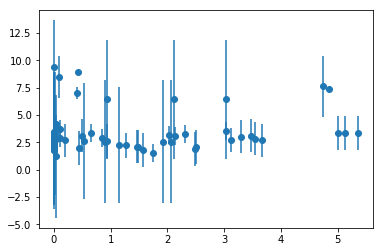

In [6]:
# Plot predicted values with errors against MP calculated values
plt.errorbar(mp_bandgaps[0:100], prediction_values[0:100], prediction_errors[0:100], fmt='o');
plt.show()

In [7]:
# check to see how well predicted values match MP calculated bandgaps
corr = pearsonr(prediction_values, mp_bandgaps)
print(corr)

(0.38485268738345707, 1.0027217642930977e-61)


## More advanced dataset queries through Citrination API

In [8]:
mp = MPRester(environ['MP_API_KEY'])
kpointdata = mp.get_task_data('mp-20', prop='kpoints')
#potcar = mp.get_task_data('mp-1', prop='potcar')
#encut = mp.get_task_data('mp-1', prop='incar')

print((kpointdata[0]))

{'task_id': 'mp-20', 'kpoints': Kpoints from vasprun.xml
0
Monkhorst
10 6 6
}


In [9]:
my_dataset_id = 164094

detail_query = ValueQuery(extract_as="dep_gas_flow", extract_all=True, name=FieldQuery(filter=[Filter(equal="Argon")]))
prep_query = ProcessStepQuery(name=FieldQuery(filter=[Filter(equal="Deposition Gas Flows")]), details=detail_query)
system_query = PifSystemQuery(prepartion=prep_query)
dataset_query = DatasetQuery(id=Filter(equal=str(my_dataset_id)))
query = DataQuery(dataset=dataset_query, system=system_query)
query_dataset = PifSystemReturningQuery(size=5, query=query)

query_result = client.search.pif_search(query_dataset)

print("Found {} PIFs".format(query_result.total_num_hits))
print([x.extracted for x in query_result.hits])

Found 57377 PIFs
[None, None, None, None, None]


## Conclusion
To recap, this notebook provided examples on using the Citrination and Materials Project APIs. Specifically, we used a pre-trained model on Citrination to run batch predictions on a set of data from the Materials Project. We then calculated the Pearson correlation coefficient and plotted the predicted values. Finally, we concluded with an example on how to contruct queries to the Citrination platform.